A notebook to run star separation analysis, but re-using calibration files, so that I can get quicker to the donut part 

In [1]:
import os
import argparse
import numpy as np

In [1]:
import sys
sys.path.append('../analysis_scripts/')
from baseComcamLoop import _eraseFolderContent
from createPhosimCatalogNew import createPhosimCatalog
from lsst.ts.phosim.Utility import getPhoSimPath, getAoclcOutputPath, getConfigDir
from lsst.ts.wep.Utility import runProgram

ModuleNotFoundError: No module named 'lsst'

In [ ]:
# Load directory paths
phosimDir = getPhoSimPath()
#outputDir = getAoclcOutputPath()
testLabel = 'sep'
#skyFilePath = args.skyFile


# read the star brightness
magVal   = 16


# settings for simulation
numPro = 60 # number of processors setting in phosimCmptSetting.yaml 
iterNum  = 1 # number of iterations 
numFields = 9 # 9 for all CCDs,  3 to get the result quicker... 

testOutputDir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/'
os.environ["closeLoopTestDir"] = testOutputDir


# We create a PhoSim catalog with 2 stars with magVal brightness,
# with varying separation in degrees     
numStars  = 2 
opd = False
flats = False
defocalImg = True

# since at such small separations the donuts overlap, we need to 
# turn on the deblending ....
doDeblending = True 

magList = np.ones(numStars) * magVal
for starSep in [8] : 
    print('\nStarting ccLoop for separation equal to %d percent of amplifier ra span '%starSep)

    outputDir = testOutputDir+'singleAmp/sep_%d' % starSep
    print(outputDir)
    if (not os.path.exists(outputDir)):
        os.makedirs(outputDir)

    # re-use the flats and calibs : copy from the sep_10  ...

    if not opd and not flats : 
        print('Copying content of /sep_10/ to re-use the flats and OPD files...')
        argString = '-a ../analysis_scripts/singleAmp/sep_10/. '+ outputDir+'/'
        runProgram("cp", argstring=argString)

        # ensure that input/raw and input/rerun are empty 
        print('Deleting content of input/raw/ and input/rerun/')
        _eraseFolderContent(os.path.join(outputDir, 'input','raw'))
        _eraseFolderContent(os.path.join(outputDir, 'input','rerun'))

        # remove files that are remade
        argString = os.path.join(outputDir, 'input')
        runProgram("rm", argstring=argString+'/isr*')
        runProgram("rm", argstring=argString+'/registry*')
        runProgram("rm", argstring=argString+'/_mappe*')

    # Clobber
    if opd is True:
        print('We will make new OPD files in this run')
        _eraseFolderContent(outputDir)
    else:
        if flats is True:
            print('We will make new flats in this run')
            _eraseFolderContent(os.path.join(outputDir, 'fake_flats'))
            _eraseFolderContent(os.path.join(outputDir, 'input'))     
        if defocalImg is True:
            print('We will make new defocal images in this run ')
            intraPath = os.path.join(outputDir, 'iter0', 'img', 'intra')
            extraPath = os.path.join(outputDir, 'iter0', 'img', 'extra')
            if os.path.exists(intraPath):
                _eraseFolderContent(intraPath)
            if os.path.exists(extraPath):
                _eraseFolderContent(extraPath)




In [ ]:
# use this star catalog...
skyFilePath = testOutputDir+'singleAmp/starCat_%d.txt'%starSep



In [ ]:
skyFilePath



In [ ]:
import os
import argparse
import numpy as np
import shutil

from lsst.ts.wep.ParamReader import ParamReader
from lsst.ts.wep.Utility import FilterType, CamType, runProgram
from lsst.ts.wep.ctrlIntf.WEPCalculationFactory import WEPCalculationFactory
from lsst.ts.wep.ctrlIntf.RawExpData import RawExpData

from lsst.ts.ofc.Utility import InstName
from lsst.ts.ofc.ctrlIntf.OFCCalculationFactory import OFCCalculationFactory

from lsst.ts.phosim.telescope.TeleFacade import TeleFacade
from lsst.ts.phosim.PhosimCmpt import PhosimCmpt
from lsst.ts.phosim.SkySim import SkySim
from lsst.ts.phosim.Utility import getPhoSimPath, getAoclcOutputPath, \
                                   getConfigDir
from lsst.ts.phosim.PlotUtil import plotFwhmOfIters


Instead of dissecting every bit of baseComCamLoop,  just skip to the main part of `listOfWfErr = wepCalc.calculateWavefrontErrors`, where `wepCalc = self._prepareWepCalc`, which is an instance of `wepCalc = WEPCalculationFactory.getCalculator`

In [ ]:
# passing params to baseComcamLoop.py:
#phosimDir, numPro, iterNum, 
baseOutputDir=outputDir
testName = '%s.%d' % (testLabel, starSep), 
isEimg=False; genOpd=opd; genDefocalImg=defocalImg
genFlats=flats; useMinDofIdx=False
inputSkyFilePath=skyFilePath; m1m3ForceError=0.05



In [ ]:
from baseComcamLoop import baseComcamLoop
import baseComcamLoop as self 



The bad coding trick above allows me to use the routines as-written...

In [ ]:
# Prepare the calibration products (only for the amplifier images)
sensorNameList = baseComcamLoop._getComCamSensorNameList(self)
if ((not isEimg) & (genFlats is True)):
    fakeFlatDir = baseComcamLoop._makeCalibs(baseOutputDir, sensorNameList)

     # Make the ISR directory
isrDirName = "input"
isrDir = os.path.join(baseOutputDir, isrDirName)
if genFlats is True:
    baseComcamLoop._makeDir(isrDir)
    
    

In [ ]:
surveyFilter=None
# Survey parameters
surveySettingFilePath = os.path.join(getConfigDir(),
                                    "surveySettings.yaml")
surveySettings = ParamReader(filePath=surveySettingFilePath)
if surveyFilter is None:
    filterType = FilterType.fromString(
        surveySettings.getSetting("filterType"))
else:
    filterType = FilterType.fromString(surveyFilter)
raInDeg = surveySettings.getSetting("raInDeg")
decInDeg = surveySettings.getSetting("decInDeg")
rotAngInDeg = surveySettings.getSetting("rotAngInDeg")




In [ ]:
rotAngInDeg

In [ ]:
# Prepare the components
phosimCmpt = baseComcamLoop._preparePhosimCmpt(self,phosimDir, filterType, raInDeg, decInDeg,
                                               rotAngInDeg, numPro, isEimg, m1m3ForceError)

wepCalc = baseComcamLoop._prepareWepCalc(self,isrDir, filterType, raInDeg, decInDeg,
                        rotAngInDeg, isEimg, doDeblending)

'''  
def _prepareWepCalc(self, isrDirPath, filterType, raInDeg, decInDeg, rotAngInDeg,
                        isEimg,doDeblending):

        wepCalc = WEPCalculationFactory.getCalculator(CamType.ComCam, isrDirPath)
        wepCalc.setFilter(filterType)
        wepCalc.setBoresight(raInDeg, decInDeg)
        wepCalc.setRotAng(rotAngInDeg)

        if (isEimg):
            settingFile = wepCalc.getSettingFile()
            settingFile.updateSetting("imageType", "eimage")

        if (doDeblending):
            settingFile = wepCalc.getSettingFile()
            settingFile.updateSetting("doDeblending", "True") 

        return wepCalc
'''

tele = phosimCmpt.getTele()
defocalDisInMm = tele.getDefocalDistInMm()
wepCalc.setDefocalDisInMm(defocalDisInMm)

ofcCalc = baseComcamLoop._prepareOfcCalc(self,filterType, rotAngInDeg)




In [ ]:
defocalDisInMm


In [ ]:
# Ingest the calibration products (only for the amplifier images,
# and if generated new flats... )
if ((not isEimg) & (genFlats is True)):
    wepCalc.ingestCalibs(fakeFlatDir)


# Set the telescope state to be the same as the OFC
state0 = ofcCalc.getStateAggregated()
'''Get the aggregated state (or degree of freedom, DOF).

The default output units are:
1. M2 hexapod position (dz in um, dx in um, dy in um, rx in arcsec,
ry in arcsec).
2. Cam hexapod position (dz in um, dx in um, dy in um, rx in arcsec,
ry in arcsec).
3. M1M3 20 bending mode in um.
4. M2 20 bending mode in um.
'''

phosimCmpt.setDofInUm(state0)
# it's all 0's... 
# 


In [ ]:
wepCalc.ingestCalibs??


In [ ]:
# Do the iteration
obsId = 9006000
testName = testName[0]
opdZkFileName = str("opd.zer" + '.' + testName)
wfsZkFileName = str("wfs.zer" + '.' + testName)
opdPssnFileName = "PSSN.txt"
outputDirName = "pert"
outputImgDirName = "img"
iterDefaultDirName = "iter"
dofInUmFileName = "dofPertInNextIter.mat"
skyInfoFileName = "skyComCamInfo.txt"
#for iterCount in range(iterNum):
iterCount = 0
# Set the observation Id
phosimCmpt.setSurveyParam(obsId=obsId)

# The iteration directory
iterDirName = "%s%d" % (iterDefaultDirName, iterCount)

# Set the output directory
outputDir = os.path.join(baseOutputDir, iterDirName, outputDirName)
phosimCmpt.setOutputDir(outputDir)
print('PhoSim outputDir is %s'%outputDir)
# Set the output image directory
outputImgDir = os.path.join(baseOutputDir, iterDirName,
                            outputImgDirName)
phosimCmpt.setOutputImgDir(outputImgDir)
print('PhoSim outputImgDir is %s'%outputImgDir)
# Generate the OPD image
if genOpd is True:

    argString = phosimCmpt.getComCamOpdArgsAndFilesForPhoSim()
    argString = '-w ' + baseOutputDir+ ' '+ argString
    #argString = '-w $AOCLCOUTPUTPATH ' + argString
    print('Generating OPD with Phosim, argString is \n')
    print(argString)
    phosimCmpt.runPhoSim(argString)
    
    

In [ ]:
baseOutputDir

In [ ]:
# Analyze the OPD data
phosimCmpt.analyzeComCamOpdData(zkFileName=opdZkFileName,
                                pssnFileName=opdPssnFileName)
'''
self._writeOpdZkFile(zkFileName, rotOpdInDeg)
self._writeOpdPssnFile(pssnFileName)
'''
# Get the PSSN from file
pssn = phosimCmpt.getOpdPssnFromFile(opdPssnFileName)
print("Calculated PSSN is %s." % pssn)

# Get the GQ effective FWHM from file
gqEffFwhm = phosimCmpt.getOpdGqEffFwhmFromFile(opdPssnFileName)
print("GQ effective FWHM is %.4f." % gqEffFwhm)

# Set the FWHM data
listOfFWHMSensorData = phosimCmpt.getListOfFwhmSensorData(
    opdPssnFileName, sensorNameList)
ofcCalc.setFWHMSensorDataOfCam(listOfFWHMSensorData)



In [ ]:
phosimCmpt._writeOpdPssnFile??

In [ ]:
phosimCmpt._writeOpdZkFile??

In [ ]:
ofcCalc._getEffPssn

In [ ]:
sensorId = np.array([], dtype=int)
pssn = np.array([])
for aFWHMSensorData in listOfFWHMSensorData:

    sensorId = np.append(sensorId, aFWHMSensorData.getSensorId())

    fwhm = aFWHMSensorData.getFwhmValues()
    pssnOfSensor = ofcCalc.fwhmToPssn.convertToPssn(fwhm)
    effPssn = ofcCalc._getEffPssn(pssnOfSensor)
    pssn = np.append(pssn, effPssn)

In [ ]:
sensorId

In [ ]:
pssn

In [ ]:
print(inputSkyFilePath)
# Prepare the faked sky
if (inputSkyFilePath == ""):
    # According to the OPD field positions
    metr = phosimCmpt.getOpdMetr()
    skySim = baseComcamLoop._prepareSkySim(metr, starMag)
    print("Use the default OPD field positions to be star positions.")
    print("The star magnitude is chosen to be %.2f." % starMag)
else:
    skySim = baseComcamLoop._prepareSkySimBySkyFile(self,inputSkyFilePath)

# Output the sky information
skySim, wepCalc = baseComcamLoop._outputSkyInfo(self,outputDir, skyInfoFileName, skySim, wepCalc)



In [ ]:
wepCalc.isrDir



In [ ]:
# Assign the entra- and intra-focal observation Id
extraObsId = obsId + 1
intraObsId = obsId + 2

# Generate the defocal images
simSeed = 1000
argStringList = phosimCmpt.getComCamStarArgsAndFilesForPhoSim(
    extraObsId, intraObsId, skySim, simSeed=simSeed,
    cmdSettingFileName="starDefault.cmd",
    instSettingFileName="starSingleExp.inst")
if genDefocalImg is True:
    for argString in argStringList:
        #argString = '-w $AOCLCOUTPUTPATH ' + argString
        argString = '-w ' + baseOutputDir+ ' '+ argString
        print('Generating defocal images with Phosim\n')
        print(argString)
        phosimCmpt.runPhoSim(argString)

    # Repackage the images based on the image type
    if (isEimg):
        phosimCmpt.repackageComCamEimgFromPhoSim()
    else:
        phosimCmpt.repackageComCamAmpImgFromPhoSim()


In [ ]:

postageImgDir



In [ ]:
# Collect the defocal images
intraRawExpData = RawExpData()
intraRawExpDir = os.path.join(outputImgDir,
                            phosimCmpt.getIntraFocalDirName())
intraRawExpData.append(intraObsId, 0, intraRawExpDir)

extraRawExpData = RawExpData()
extraRawExpDir = os.path.join(outputImgDir,
                            phosimCmpt.getExtraFocalDirName())
extraRawExpData.append(extraObsId, 0, extraRawExpDir)


In [ ]:
intraRawExpData.getRawExpDir()

In [ ]:
outputImgDir

In [ ]:
baseComcamLoop._makeDir??


In [ ]:
# Calculate the wavefront error and DOF
postageImgDir  = os.path.join(baseOutputDir,'postage')
if not os.path.exists(postageImgDir):
    os.makedirs(postageImgDir)

In [ ]:

listOfWfErr = wepCalc.calculateWavefrontErrors(intraRawExpData, extraRawExpData=extraRawExpData,postageImg=True,
                                              postageImgDir = postageImgDir)


### Inside wepCalc.calculateWavefrontErrors() l.328 in WEPCalculation.py

In [ ]:
# Inside wepCalc.calculateWavefrontErrors()
rawExpData = intraRawExpData
if (extraRawExpData is None):
    raise ValueError("Corner WFS is not supported yet.")

if (len(rawExpData.getVisit()) != 1):
    raise ValueError("Only single visit is allowed at this time.")

In [ ]:
# When evaluating the eimage, the calibration products are not needed.
# Therefore, need to make sure the camera mapper file exists.
wepCalc._genCamMapperIfNeed()

In [ ]:
# Ingest the exposure data and do the ISR
wepCalc._ingestImg(rawExpData)
if (extraRawExpData is not None):
    wepCalc._ingestImg(extraRawExpData)

In [ ]:
# Only the amplifier image needs to do the ISR
imgType = wepCalc._getImageType()
if (imgType == ImageType.Amp):
    wepCalc._doIsr(isrConfigfileName="isr_config.py")

In [ ]:
# Set the butler inputs path to get the images
butlerRootPath = wepCalc._getButlerRootPath()
print(butlerRootPath)
wepCalc.wepCntlr.setPostIsrCcdInputs(butlerRootPath)

In [ ]:
# Get the target stars map neighboring stars
neighborStarMap = wepCalc._getTargetStar()



In [ ]:
extraRawExpData.getRawExpDir()

In [ ]:
# Calculate the wavefront error
intraObsIdList = rawExpData.getVisit()
intraObsId = intraObsIdList[0]
if (extraRawExpData is None):
    obsIdList = [intraObsId]
else:
    extraObsIdList = extraRawExpData.getVisit()
    extraObsId = extraObsIdList[0]
    obsIdList = [intraObsId, extraObsId]
    
# now 
# donutMap = self._calcWfErr(neighborStarMap, obsIdList)
# is called : 

### Inside donutMap =  wepCalc._calcWfErr(), l.562 in WEPCalculation.py 

In [ ]:
from lsst.ts.wep.Utility import getModulePath, getConfigDir, BscDbType, \
    FilterType, abbrevDectectorName, getBscDbType, getImageType, \
    getCentroidFindType, ImageType

In [ ]:
sensorNameList = list(neighborStarMap)
print(sensorNameList)

In [ ]:
imgType = wepCalc._getImageType()
if (imgType == ImageType.Amp):
    wfsImgMap = wepCalc.wepCntlr.getPostIsrImgMapByPistonDefocal(
        sensorNameList, obsIdList)
    # calls wepCalc.wepCntrlr._getImgMapByPistonDefocal
elif (imgType == ImageType.Eimg):
    wfsImgMap = wepCalc.wepCntlr.getEimgMapByPistonDefocal(
        sensorNameList, obsIdList)


In [ ]:
wepCalc.wepCntlr._getImgMapByPistonDefocal??

In [ ]:
wfsImgMap['R:2,2 S:0,2'].getIntraImg()

In [ ]:
doDeblending = wepCalc.settingFile.getSetting("doDeblending")
print(doDeblending)


In [ ]:
#Now donutMap = self.wepCntlr.getDonutMap(
#    neighborStarMap, wfsImgMap, self.getFilter(),
#    doDeblending=doDeblending)  is called ... 

### Inside wepCalc.wepCntlr.getDonutMap() : l.316 of WepController.py 

In [ ]:
neighborStarMap.items()

In [ ]:
postageImg = True

In [ ]:
donutMap = dict()

for sensorName, nbrStar in neighborStarMap.items() :
    #print(sensorName, nbrStar)
    
     # Get the abbraviated sensor name
    abbrevName = abbrevDectectorName(sensorName)
    print('abbrev sensor name is %s'%abbrevName)
    # Configure the source processor 
    # self here is wepCalc.wepCntlr
    wepCalc.wepCntlr.sourProc.config(sensorName=abbrevName)

    # Get the defocal images: [intra, extra]
    defocalImgList = [wfsImgMap[sensorName].getIntraImg(),
                      wfsImgMap[sensorName].getExtraImg()]

    # Get the bright star id list on specific sensor
    brightStarIdList = list(nbrStar.getId())
    
    for starIdIdx in range(len(brightStarIdList)):
        print('starIdIdx is %d'%starIdIdx)
        # Get the single star map
        # iterate over [intra, extra] focal images 
        for jj,pre in zip(range(len(defocalImgList)),['intra','extra']): 

            ccdImg = defocalImgList[jj] # these are image arrays 
            print(pre)
            # Get the segment of image
            if (ccdImg is not None):
                singleSciNeiImg, allStarPosX, allStarPosY, magRatio, \
                    offsetX, offsetY = \
                    wepCalc.wepCntlr.sourProc.getSingleTargetImage(
                        ccdImg, nbrStar, starIdIdx, filterType)
                if postageImg: 
                    fname = postageImgDir+'/'+pre+'_singleSciImg_sensor-'+abbrevName+\
                            '_star-'+str(starIdIdx)+'.txt'
                    np.savetxt(fname,singleSciNeiImg)
                    print('Saving postage stamp image as %s'%fname)

                    
                    
                
               

In [ ]:
postageImgDir

In [ ]:
if (imgType == ImageType.Amp):
    wfsImgMap = wepCalc.wepCntlr.getPostIsrImgMapByPistonDefocal(
            sensorNameList, obsIdList)

In [ ]:
# Calculate the wavefront error
intraObsIdList = rawExpData.getVisit()
intraObsId = intraObsIdList[0]
if (extraRawExpData is None):
    obsIdList = [intraObsId]
else:
  extraObsIdList = extraRawExpData.getVisit()
  extraObsId = extraObsIdList[0]
      obsIdList = [intraObsId, extraObsId]


Here wepCalc is invoking `calculateWavefrontErrors` in https://github.com/lsst-ts/ts_wep/blob/master/python/lsst/ts/wep/ctrlIntf/WEPCalculation.py, which:
* `self._genCamMapperIfNeed()` : searches for `_mapper` file in the `wepcalc.isrDir` (which is `/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/singleAmp/sep_8/input`)   
*  `# Ingest the exposure data and do the ISR
        self._ingestImg(rawExpData)
        if (extraRawExpData is not None):
            self._ingestImg(extraRawExpData)
    `: that ingests with butler the intra and extra focal images 
* performs the ISR for amplifier image : ` 
        imgType = self._getImageType()
        if (imgType == ImageType.Amp):
            self._doIsr(isrConfigfileName="isr_config.py") `
*      
      `# Set the butler inputs path to get the images
        butlerRootPath = self._getButlerRootPath()
        self.wepCntlr.setPostIsrCcdInputs(butlerRootPath) ` 
    which is wepcalc.isrDir + `rerun` + rerunName , which is set in setting file 


* makes the `neighborStarMap = self._getTargetStar()` which connects to the database 

* calculates the wavefront error: 
    
      # Calculate the wavefront error
        intraObsIdList = rawExpData.getVisit()
        intraObsId = intraObsIdList[0]
        if (extraRawExpData is None):
            obsIdList = [intraObsId]
        else:
            extraObsIdList = extraRawExpData.getVisit()
            extraObsId = extraObsIdList[0]
            obsIdList = [intraObsId, extraObsId]
            
        donutMap = self._calcWfErr(neighborStarMap, obsIdList)
        
  the last line (l.391) invokes `_calcWfErr`, which :

  * gets the image map (defocal image on the camera coordinate) in l.591 : 
   ` wfsImgMap = self.wepCntlr.getPostIsrImgMapByPistonDefocal(sensorNameList, obsIdList)` - it uses exposure `exp = self.butlerWrapper.getPostIsrCcd(int(visit), raft, sensor)`(l.201 of `WepController.py`), to get the image `img = self.butlerWrapper.getImageData(exp)`, and transforms the image in DM coordinate to camera coordinate:`camImg = self._transImgDmCoorToCamCoor(img)`. `wfsImgMap` contains `camImg` for each sensor. 
   
  * then creates the donut map: 
        
        ```doDeblending = self.settingFile.getSetting("doDeblending")
        donutMap = self.wepCntlr.getDonutMap(
        neighborStarMap, wfsImgMap, self.getFilter(),
        doDeblending=doDeblending)```  
       Invoking `getDonutMap` from `WepController.py` : here lines 367 and 403  can be used to extract the image :
       
       l.367   np.savetxt('/astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/singleSciNeiImg.out', singleSciNeiImg)
       l.403 
       np.savetxt('/astro/store/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/imgDeblend.out', imgDeblend)
        

Look at postage stamp images ...

In [ ]:
loc = '../analysis_scripts/'
pre = np.loadtxt(loc+'singleSciNeiImg.out')

In [ ]:
fname = postageImgDir+'/'+pre+'_singleSciImg_sensor-'+abbrevName+\
                            '_star-'+str(starIdIdx)+'.txt'

In [ ]:
postageI

In [ ]:
postageImgDir

In [ ]:
raft = 'R22'
imgType = ['singleSciImg','imgDeblend_full', 'imgDeblend_resized']
chip = '00'
sensor = raft+'_S'+chip

focalType = 'intra'
Nstars = 2 
fig,ax = plt.subplots(Nstars,len(imgType),figsize=(12,8))
for col in range(len(imgType)): # columns : each imgType is one column 
    ax[0,col].set_title(imgType[col], fontsize=17)
    for row in range(Nstars): # rows : one per star
        fname = focalType+'_'+imgType[col]+"_sensor-"+sensor+"_star-"+str(row)+'.txt'
        image = np.loadtxt(postageImgDir+'/'+fname)
        ax[row,col].imshow(image)
        ax[row,col].text(0.1,0.1,'star %d'%row , fontsize=17, color='white', transform=ax[row,col].transAxes)



In [ ]:
%matplotlib inline

raft = 'R22'
imgType = ['singleSciImg','imgDeblend']
for chip in ['00','01','02','10','11', '12','20','21','22']:
    sensor = raft+'_S'+chip
    for focalType in ['intra','extra']:
        fig,ax = plt.subplots(2,2,figsize=(10,10))
        for i in range(len(imgType)):
            for j in range(2): # two stars per CCD 
                fname = focalType+'_'+imgType[i]+"_sensor-"+sensor+"_star-"+str(j)+'.txt'
                image = np.loadtxt(postageImgDir+'/'+fname)
                ax[j,i].imshow(image)
                ax[j,i].text(0.1,0.1,'star %d'%j , fontsize=17, color='white', transform=ax[j,i].transAxes)
        ax[0,0].set_title(imgType[0], fontsize=17)
        ax[0,1].set_title(imgType[1], fontsize=17)
        fig.suptitle(sensor+' '+focalType, fontsize=17)
        plt.savefig(focalType+'_'+sensor+'.png', bbox_inches='tight')

In [ ]:
This confirms that (at least for separation of 8%, i.e. )

In [ ]:
post = np.loadtxt(loc+'imgDeblend.out')
plt.imshow(post)

In [ ]:
from lsst.ts.wep.ButlerWrapper import ButlerWrapper
from lsst.ts.wep.DefocalImage import DefocalImage
from lsst.ts.wep.DonutImage import DonutImage
from lsst.ts.wep.Utility import abbrevDectectorName, searchDonutPos, \
    DefocalType, ImageType

## Print postage stamps for the same sensor across various separations: *singleAmpSep* test, using *old vs new centroid* code: '

In [ ]:
accessDir = '/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/'
expDir = 'singleAmpSep'

for when in  ['before', 'after']:
    topDir = 'results_'+when+'_centroid_update'

    #starSep = 6
    for starSep in np.arange(1,11)[::-1]:
        outputDir= os.path.join(accessDir,topDir,expDir,'sep_%d' % starSep)
        baseOutputDir = outputDir
        postageImgDir = os.path.join(baseOutputDir,'postage')
        raft = 'R22'
        imgType = ['singleSciImg','imgDeblend_full', 'imgDeblend_resized']
        chip = '00'
        sensor = raft+'_S'+chip

        focalType = 'intra'
        Nstars = 2 
        fig,ax = plt.subplots(Nstars,len(imgType),figsize=(12,8))
        for col in range(len(imgType)): # columns : each imgType is one column 
            ax[0,col].set_title(imgType[col], fontsize=17)
            for row in range(Nstars): # rows : one per star
                fname = focalType+'_'+imgType[col]+"_sensor-"+sensor+"_star-"+str(row)+'.txt'
                image = np.loadtxt(postageImgDir+'/'+fname)
                mappable = ax[row,col].imshow(image)
                ax[row,col].text(0.1,0.1,'star %d'%row , fontsize=17, color='white', transform=ax[row,col].transAxes)

        cbar_ax = fig.add_axes([0.93, 0.12, 0.02, 0.76])     #  (x0 ,y0  , dx,  dy )  
        cbar = fig.colorbar(mappable, cax = cbar_ax,  orientation='vertical')                    
        cbar.set_label(label='counts',weight='normal', fontsize=17)
        
        # calculate the separation in units of donut radii ... 
        amplifierSpanPx = 2048 # in pixels
        donutPxRadius = 66 # in pixels 
        sepInPx = starSep*0.01*amplifierSpanPx
        sepInRadii = sepInPx / donutPxRadius  # convert separation to units of donut radii 

        figtitle= 'Separation %.2f '%sepInRadii+r'$R_{\mathrm{Donut}}$,'+sensor+' '+focalType+ '-focal, '+when
        fig.suptitle(figtitle, fontsize=17)

        plt.savefig(when+'_Sep_%d_percAmpSpan_postageImg.png'%starSep, bbox_inches='tight', dpi=100)

## Postage stamps for the same sensor with sep = 5%, varying the brightness of the companion star :  *singleAmpMag* test (using *old vs new centroid* code ) 

In [ ]:
%matplotlib inline

accessDir = '/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/'
expDir = 'singleAmpMag'
for when in ['before', 'after']:
    topDir = 'results_'+when+'_centroid_update'
    for mag in [16,15,14,13,12,11,10]:
        outputDir= os.path.join(accessDir,topDir,expDir,'mag_%d' % mag)
        baseOutputDir = outputDir
        postageImgDir = os.path.join(baseOutputDir,'postage')
        raft = 'R22'
        imgType = ['singleSciImg','imgDeblend_full', 'imgDeblend_resized']
        chip = '00'
        sensor = raft+'_S'+chip

        focalType = 'intra'
        Nstars = 2
        fig,ax = plt.subplots(Nstars,len(imgType),figsize=(12,8))
        for col in range(len(imgType)): # columns : each imgType is one column 
            ax[0,col].set_title(imgType[col], fontsize=17)
            for row in range(Nstars): # rows : one per star
                fname = focalType+'_'+imgType[col]+"_sensor-"+sensor+"_star-"+str(row)+'.txt'
                image = np.loadtxt(postageImgDir+'/'+fname)
                ax[row,col].imshow(image)
                ax[row,col].text(0.1,0.1,'star %d'%row , fontsize=17, color='white', transform=ax[row,col].transAxes)
         
        cbar_ax = fig.add_axes([0.93, 0.12, 0.02, 0.76])     #  (x0 ,y0  , dx,  dy )  
        cbar = fig.colorbar(mappable, cax = cbar_ax,  orientation='vertical')                    
        cbar.set_label(label='counts',weight='normal', fontsize=17)
        
        # calculate the separation in units of donut radii ... 
        amplifierSpanPx = 2048 # in pixels
        donutPxRadius = 66 # in pixels 
        sepInPx = starSep*0.01*amplifierSpanPx
        sepInRadii = sepInPx / donutPxRadius  # convert separation to units of donut radii 

        figtitle= 'Sep=%.2f '%sepInRadii+r'$R_{\mathrm{Donut}}$, '+ \
        r'$\Delta =%d$mag, ' % (16-mag)+sensor+' '+focalType+ '-focal, '+when
        fig.suptitle(figtitle, fontsize=17)
        plt.savefig(when+'_Mag_%d_postageImg.png'%mag, bbox_inches='tight', dpi=100)

## Plot stamps for GAIA star catalog ... 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import os

In [10]:
%matplotlib inline

accessDir = '/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/'
topDir = 'results_gaia'
expDir = 'gMagGt11_R22' #'noMagCut'

outputDir= os.path.join(accessDir,topDir,expDir)
baseOutputDir = outputDir
postageImgDir = os.path.join(baseOutputDir,'postage')


extra_singleSciImg_sensor-R22_S01_star-0_id-1096.txt
extra_singleSciImg_sensor-R22_S01_star-1_id-1447.txt
extra_singleSciImg_sensor-R22_S01_star-2_id-1490.txt
extra_singleSciImg_sensor-R22_S01_star-3_id-1554.txt
extra_singleSciImg_sensor-R22_S01_star-4_id-1612.txt
extra_singleSciImg_sensor-R22_S01_star-5_id-1615.txt
extra_singleSciImg_sensor-R22_S01_star-6_id-1715.txt
extra_singleSciImg_sensor-R22_S01_star-7_id-1780.txt
extra_singleSciImg_sensor-R22_S01_star-8_id-1790.txt
extra_imgDeblend_full_sensor-R22_S01_star-0_id-1096.txt
extra_imgDeblend_full_sensor-R22_S01_star-1_id-1447.txt
extra_imgDeblend_full_sensor-R22_S01_star-2_id-1490.txt
extra_imgDeblend_full_sensor-R22_S01_star-3_id-1554.txt
extra_imgDeblend_full_sensor-R22_S01_star-4_id-1612.txt
extra_imgDeblend_full_sensor-R22_S01_star-5_id-1615.txt
extra_imgDeblend_full_sensor-R22_S01_star-6_id-1715.txt
extra_imgDeblend_full_sensor-R22_S01_star-7_id-1780.txt
extra_imgDeblend_full_sensor-R22_S01_star-8_id-1790.txt
extra_imgDeblend_re

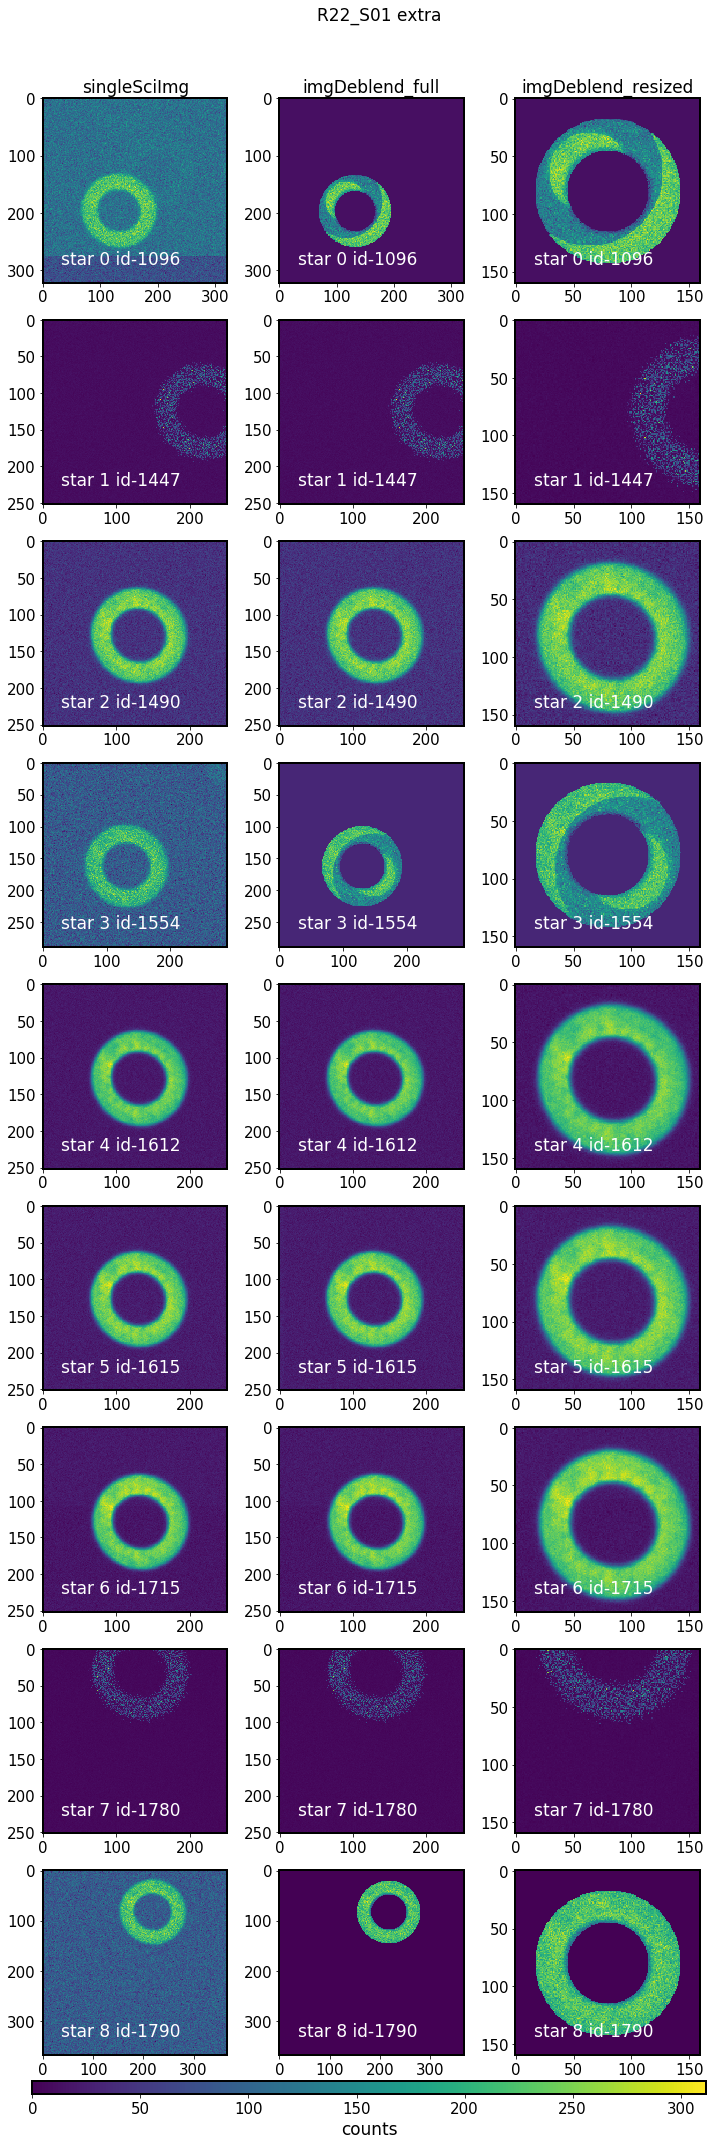

In [55]:
raft = 'R22' # the ComCam raft 
imgType = ['singleSciImg','imgDeblend_full', 'imgDeblend_resized']
chip = '01'
sensor = raft+'_S'+chip

focalType = 'extra'
Nstars = 9
fig,ax = plt.subplots(Nstars,len(imgType),figsize=(12,4*Nstars))


for col in range(len(imgType)): # columns : each imgType is one column 
    ax[0,col].set_title(imgType[col], fontsize=17)
    for row in range(Nstars): # Nstars   rows : one per star
        fname = focalType+'_'+imgType[col]+"_sensor-"+sensor+"_star-"+str(row)+'_'
        #print(fname)
        for x in os.listdir(postageImgDir):
            if x.startswith(fname): 
                print(x)
                fname = x
        image = np.loadtxt(postageImgDir+'/'+fname)
        if image.ndim == 2  :
            mappable = ax[row,col].imshow(image)
            ax[row,col].text(0.1,0.1,'star %d %s'%(row,fname[-11:-4]) , fontsize=17, color='white', transform=ax[row,col].transAxes)
        else:
            ax[row,col].remove()
            ax[row,col].text(0.2,0.5, 'image.ndim < 2 ',fontsize=15,
                        transform=ax[row,col].transAxes)
            
# that's for vertical cbar on the right 
#cbar_ax = fig.add_axes([0.93, 0.12, 0.02, 0.76])     #  (x0 ,y0  , dx,  dy )  
#cbar = fig.colorbar(mappable, cax = cbar_ax,  orientation='vertical')      

# that's for horizontal cbar on the bottom 
cbar_ax = fig.add_axes([0.12, 0.11, 0.78, 0.005])     #  (x0 ,y0  , dx,  dy )  
cbar = fig.colorbar(mappable, cax = cbar_ax,  orientation='horizontal')                    
cbar.set_label(label='counts',weight='normal', fontsize=17)

# calculate the separation in units of donut radii ... 
# amplifierSpanPx = 2048 # in pixels
# donutPxRadius = 66 # in pixels 
# sepInPx = starSep*0.01*amplifierSpanPx
# sepInRadii = sepInPx / donutPxRadius  # convert separation to units of donut radii 

#figtitle= 'Sep=%.2f '%sepInRadii+r'$R_{\mathrm{Donut}}$, '+ \
#r'$\Delta =%d$mag, ' % (16-mag)+sensor+' '+focalType+ '-focal, '+when
figtitle = sensor + ' ' + focalType
fig.text(0.45,0.91,figtitle, fontsize=17)
plt.savefig('gaia_gMagGt11_R22only_'+sensor+'_'+focalType+'_postageImg_.png', bbox_inches='tight', dpi=100)

In [ ]:




for col in range(len(imgType)): # columns : each imgType is one column 
    ax[0,col].set_title(imgType[col], fontsize=17)
    for row in range(Nstars): # Nstars   rows : one per star
        fname = focalType+'_'+imgType[col]+"_sensor-"+sensor+"_star-"+str(row)
        
        if image.ndim == 2  :
            mappable = ax[row,col].imshow(image)
            ax[row,col].text(0.1,0.1,'star %d'%row , fontsize=17, color='white', transform=ax[row,col].transAxes)
        else:
            ax[row,col].remove()
            ax[row,col].text(0.2,0.5, 'image.ndim < 2 ',fontsize=15,
                            transform=ax[row,col].transAxes)
# that's for vertical cbar on the right 
#cbar_ax = fig.add_axes([0.93, 0.12, 0.02, 0.76])     #  (x0 ,y0  , dx,  dy )  
#cbar = fig.colorbar(mappable, cax = cbar_ax,  orientation='vertical')      

# that's for horizontal cbar on the bottom 
cbar_ax = fig.add_axes([0.12, 0.11, 0.78, 0.005])     #  (x0 ,y0  , dx,  dy )  
cbar = fig.colorbar(mappable, cax = cbar_ax,  orientation='horizontal')                    
cbar.set_label(label='counts',weight='normal', fontsize=17)

# calculate the separation in units of donut radii ... 
# amplifierSpanPx = 2048 # in pixels
# donutPxRadius = 66 # in pixels 
# sepInPx = starSep*0.01*amplifierSpanPx
# sepInRadii = sepInPx / donutPxRadius  # convert separation to units of donut radii 

#figtitle= 'Sep=%.2f '%sepInRadii+r'$R_{\mathrm{Donut}}$, '+ \
#r'$\Delta =%d$mag, ' % (16-mag)+sensor+' '+focalType+ '-focal, '+when
figtitle = sensor
fig.suptitle(figtitle, fontsize=17)
plt.savefig('gaia_gMagGt11_R22only_'+sensor+'_postageImg.png', bbox_inches='tight', dpi=100)

Plot with Butler the  postISR image of the problematic sensor : R22_S01: 

In [4]:
import lsst.daf.persistence as dafPersist
import lsst.daf.base        as dafBase
import lsst.afw.table as afwTable
import os 
import numpy as np 

import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
from matplotlib import rcParams 



In [61]:
accessDir = '/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/'
topDir = 'results_gaia'
expDir =  ' gMagGt11_R22_'# 'gMagGt11_R22' #'noMagCut'

outputDir= os.path.join(accessDir,topDir,expDir)

data_dir = outputDir
print('Reading data from \n')
print(data_dir)
repo_dir = os.path.join(data_dir, 'input/rerun/run1')
butler = dafPersist.Butler(repo_dir)

butler.getKeys('postISRCCD')


# show what keys are needed 
# by the `postISRCCD` data type.... 
# butler.getKeys('postISRCCD')
# yields {'visit': int,
# 'filter': str,
# 'raftName': str,
# 'detectorName': str,
# 'detector': int}

focalType = 'extra'  # choose whihc 
obsIdDic = {'intra':9006001,  'extra':9006002}
obsId = obsIdDic[focalType] # intra 

detectors = ['S00', 'S01', 'S02','S10', 'S11', 'S12', 'S20', 'S21', 'S22']
raft = 'R22'
detector = 'S01'

sensor = raft+'_S'+detector 

detNumDict = {'S00':90, 'S01':91, 'S02':92, 'S10':93, 'S11':94, 'S12':95, 'S20':96, 'S21':97, 'S22':98}
detNum = detNumDict[detector]

data_id = {'visit': obsId, 'filter': 'g', 'raftName': raft, 'detectorName': detector, 'detector': detNum}
post = butler.get('postISRCCD', **data_id)  # doesn't show anything ...  ? 

Reading data from 

/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/gMagGt11_R22


Below we plot the postISR image of  the sensor R22_S01, with the square marking the location of the starId 1790 (`intraDonut.getPixelPos() = 2950,79`, so that below I plot it as `(79,2950)` because the image is not transposed) for which the wfs pipeline fails, as it is unable to make a square cutout....

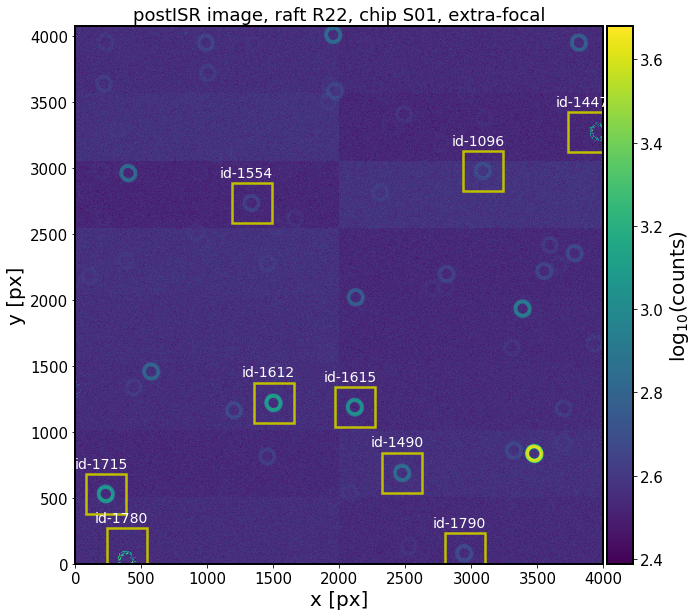

In [62]:
%matplotlib inline

# helper funtion for the colorbar 
# from https://joseph-long.com/writing/colorbars/
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

# Plot image array

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18


fig,ax = plt.subplots(1,1,figsize=(10,10))

img = ax.imshow(np.log10(post.image.array.T),cmap=cm.get_cmap('viridis'),
          origin='lower')
cbar= colorbar(mappable=img)
cbar.set_label(label=r'$\log_{10}(\mathrm{counts})$', weight='normal', )
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
ax.set_title('postISR image, raft %s, chip %s, %s-focal'%(raft,detector, focalType))




stars =  [
    ['intra_singleSciImg_sensor-R22_S01_star-0_id-1096.txt', (3090.0, 2973.0) ],
    ['intra_singleSciImg_sensor-R22_S01_star-1_id-1447.txt' ,(3880.5921897208777, 3269.5910931031826) ],
    ['intra_singleSciImg_sensor-R22_S01_star-2_id-1490.txt' ,(2476.736230873014, 687.6586759519905)],
    ['intra_singleSciImg_sensor-R22_S01_star-3_id-1554.txt' , (1335.0, 2731.0)],
    ['intra_singleSciImg_sensor-R22_S01_star-4_id-1612.txt' ,(1501.968177022672, 1217.9509274947832) ],
    ['intra_singleSciImg_sensor-R22_S01_star-5_id-1615.txt' ,(2118.6689511376276, 1185.7776987977918) ],
    ['intra_singleSciImg_sensor-R22_S01_star-6_id-1715.txt' , (231.12977605996048, 526.7951631581903)],
    ['intra_singleSciImg_sensor-R22_S01_star-7_id-1780.txt' , (387.6809135463075, 117.62911436521209)],
    ['intra_singleSciImg_sensor-R22_S01_star-8_id-1790.txt' ,(2950.0, 79.0) ],
        ]

for star in stars: 
    ax.plot(star[1][0], star[1][1], 's', markersize=40, markerfacecolor='none',
             markeredgewidth=2.5, markeredgecolor='y')
    ax.text(star[1][0]-240, star[1][1]+200, '%s'%star[0][-11:-4] , fontsize=14, color='white')
plt.savefig('gaia_gMagGt11_R22only_'+sensor+'_'+focalType+'_postISR.png', bbox_inches='tight', dpi=100)


Problematic star : 

In [35]:
stars =  [
    ['intra_singleSciImg_sensor-R22_S01_star-0_id-1096.txt', (3090.0, 2973.0) ],
    ['intra_singleSciImg_sensor-R22_S01_star-1_id-1447.txt' ,(3880.5921897208777, 3269.5910931031826) ],
    ['intra_singleSciImg_sensor-R22_S01_star-2_id-1490.txt' ,(2476.736230873014, 687.6586759519905)],
    ['intra_singleSciImg_sensor-R22_S01_star-3_id-1554.txt' , (1335.0, 2731.0)],
    ['intra_singleSciImg_sensor-R22_S01_star-4_id-1612.txt' ,(1501.968177022672, 1217.9509274947832) ],
    ['intra_singleSciImg_sensor-R22_S01_star-5_id-1615.txt' ,(2118.6689511376276, 1185.7776987977918) ],
    ['intra_singleSciImg_sensor-R22_S01_star-6_id-1715.txt' , (231.12977605996048, 526.7951631581903)],
    ['intra_singleSciImg_sensor-R22_S01_star-7_id-1780.txt' , (387.6809135463075, 117.62911436521209)],
    ['intra_singleSciImg_sensor-R22_S01_star-8_id-1790.txt' ,(2950.0, 79.0) ],
        ]

for star in stars: 
    print('for star %s, x=%d,y=%d'%(star[0][-11:-4],star[1][0], star[1][1]))

for star id-1096, x=3090,y=2973
for star id-1447, x=3880,y=3269
for star id-1490, x=2476,y=687
for star id-1554, x=1335,y=2731
for star id-1612, x=1501,y=1217
for star id-1615, x=2118,y=1185
for star id-1715, x=231,y=526
for star id-1780, x=387,y=117
for star id-1790, x=2950,y=79



    sensorName  R:2,2 S:0,1  abbrevDetectorName  R22_S01  starId= 1790  donut px pos =  (2950.0, 79.0)


In [ ]:
pwd

With camDimOffset = -50 we have a problem with a different star :  R22_S00,  extra,  star4,  id=1219 : 

In [3]:
import lsst.daf.persistence as dafPersist
import lsst.daf.base        as dafBase
import lsst.afw.table as afwTable
import os 
import numpy as np 

import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
from matplotlib import rcParams 

accessDir = '/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/'
topDir = 'results_gaia'
expDir =  'gMagGt11_R22_'# 'gMagGt11_R22' #'noMagCut'

outputDir= os.path.join(accessDir,topDir,expDir)

data_dir = outputDir
print('Reading data from \n')
print(data_dir)
repo_dir = os.path.join(data_dir, 'input/rerun/run1')
butler = dafPersist.Butler(repo_dir)

butler.getKeys('postISRCCD')


# show what keys are needed 
# by the `postISRCCD` data type.... 
# butler.getKeys('postISRCCD')
# yields {'visit': int,
# 'filter': str,
# 'raftName': str,
# 'detectorName': str,
# 'detector': int}

focalType = 'extra'  # choose whihc 
obsIdDic = {'intra':9006001,  'extra':9006002}
obsId = obsIdDic[focalType] # intra 

detectors = ['S00', 'S01', 'S02','S10', 'S11', 'S12', 'S20', 'S21', 'S22']
raft = 'R22'
detector = 'S00'

sensor = raft+'_S'+detector 

detNumDict = {'S00':90, 'S01':91, 'S02':92, 'S10':93, 'S11':94, 'S12':95, 'S20':96, 'S21':97, 'S22':98}
detNum = detNumDict[detector]

data_id = {'visit': obsId, 'filter': 'g', 'raftName': raft, 'detectorName': detector, 'detector': detNum}
post = butler.get('postISRCCD', **data_id)  # doesn't show anything ...  ? 

Reading data from 

/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/gMagGt11_R22_


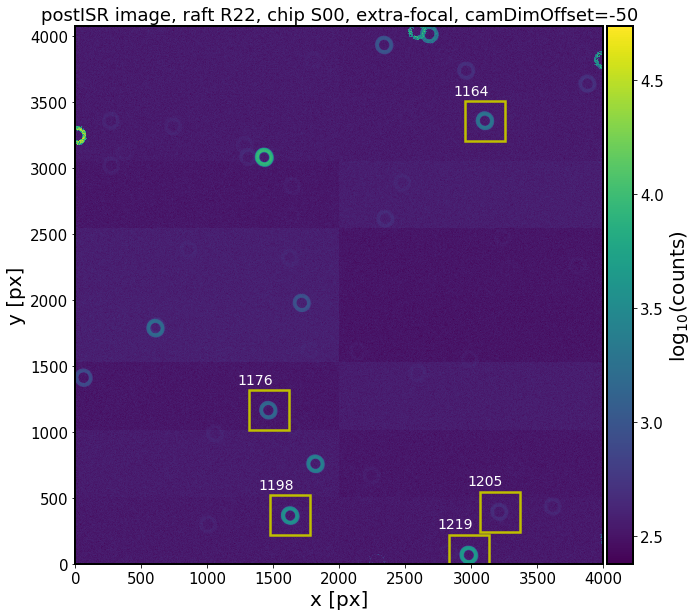

In [4]:
%matplotlib inline

# helper funtion for the colorbar 
# from https://joseph-long.com/writing/colorbars/
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

# Plot image array


camDimOffset = -50 

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18


fig,ax = plt.subplots(1,1,figsize=(10,10))

img = ax.imshow(np.log10(post.image.array.T),cmap=cm.get_cmap('viridis'),
          origin='lower')
cbar= colorbar(mappable=img)
cbar.set_label(label=r'$\log_{10}(\mathrm{counts})$', weight='normal', )
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
ax.set_title('postISR image, raft %s, chip %s, %s-focal, camDimOffset=%d'%(raft,detector, focalType,camDimOffset))




stars =  [
    ['1164', (3103.0, 3353.0)],
    ['1176' , (1467.0, 1164.0) ],
    ['1198' , (1627.0, 367.00000000000006)],
    ['1205' , (3213.0, 394.0)],
    ['1219' ,(2982.0, 68.00000000000001) ],  # problematic 
        ]

for star in stars: 
    ax.plot(star[1][0], star[1][1], 's', markersize=40, markerfacecolor='none',
             markeredgewidth=2.5, markeredgecolor='y')
    ax.text(star[1][0]-240, star[1][1]+200, '%s'%star[0] , fontsize=14, color='white')
plt.savefig('gaia_gMagGt11_R22_camDimOffset_'+sensor+'_'+focalType+'_postISR.png', bbox_inches='tight', dpi=100)
